# Smooth myopic data-driven control (C2Opt) using `congol`

We demonstrate a novel framework for on-the-fly control of autonomous systems with unknown dynamics using limited data. It utilizes unique sequential optimization algorithms for constrained global optimization. This approach can enable the post-catastrophe recovery of an autonomous system using data collected less than a few seconds long (a single finite-horizon trajectory).

In this notebook, we study the problem of driving a unicycle to origin using a finite-horizon trajectory.

### Dynamics

We denote the **unknown** discrete-time dynamics as $x^+=F(x,u)$, with the state $x=[p_x\ p_y\ \theta]\in \mathcal{X}\subset \mathbb{R}^2\times [0, 2\pi)$, and input $u=[v\ w]\in \mathcal{U}\subset \mathbb{R}^2$. Here, $(p_x, p_y)$ denotes the unicycle position in $\mathrm x$ and $\mathrm y$, $\theta$ denotes the heading, $v$ denotes the heading velocity $v$, and $w$ denotes the turning rate.

### Optimal control problem

We encode the desired behavior in a known one-step cost function $c:\mathcal{X}\times \mathcal{U}\times \mathcal{X}\to \mathbb{R}$. Since the dynamics $F$ is unknown, the one-step cost function expressed in terms of the current state and the current input $C:\mathcal{X}\times\mathcal{U}\to \mathbb{R}$ is unknown,
$$C(x,u)=c(x,u,F(x,u)).$$

The controller is synthesized by solving a *contextual optimization* problem at the current state (context) $x$,
$$u_t^\dagger = \arg\inf_{u\in\mathcal{U}} C(x_t,u)$$
To solve this contextual optimization problem, we assume access to the following data:
1. the trajectory up to time $t$, ${(x_k,u_k,x_{k+1})}_{k=0}^{t-1}$
1. the evaluation of the one-step cost function and its gradient up to time $t$, ${(C(x_k,u_k), \nabla C(x_k,u_k))}_{k=0}^{t-1}$.

Note that we do not have the evaluation of the unknown cost function or its gradients at control actions that were not tried in the environment.

### Algorithms that we compare `C2Opt` with

We compare the performance of `C2Opt` with two other known methods for control with limited data:
1. `CGP-LCB`: A contextual optimization framework using Gaussian Processes (implemented using `GPyOpt` in its standard setting)
1. `SINDYc`: Sparse identification of nonlinear dynamics for control

We also show how the optimal controller behaves if the true dynamics were known.

## Parameters for the problem

We define the state space $\mathcal{X}=[-12,2]\times[-6,2]\times[0,2\pi)$, input space $\mathcal{U}=[-4,4]\times[-\pi,\pi]$, and the initial state $x_0=[-2,-2.5,\frac{\pi}{2}]$. We use sampling time $T_s=0.1$ for obtaining the discrete-time dynamics (for the simulator only). We also specify the maximum number of time steps for the simulation, the length of the training data, and the time horizon.

In [1]:
import numpy as np

figure_3 = False

if figure_3:
    # Initial data point
    initial_state = np.array([-2, -2.5, np.pi/2])
    # Working environment
    xlim_tup = [-3, 2]
    ylim_tup = [-4.5, 2]
    # Prefix
    fig_name_prefix = 'Fig3_'
    n_data_max = 10                              # Number of data points available for precursor training
else:
    # Initial data point
    initial_state = np.array([-5, -2.5, np.pi/2])
    # Working environment
    xlim_tup = [-6, 2]
    ylim_tup = [-4.5, 3.5]
    # Prefix
    fig_name_prefix = 'Fig4_'
    n_data_max = 1                              # Number of data points available for precursor training

# Input bounds
v_max = 4
w_max = 0.5 * (2*np.pi)
v_min = -v_max
w_min = -w_max
input_lb = np.array([v_min, w_min])
input_ub = np.array([v_max, w_max])

# Sampling for the discrete time
sampling_time = 0.1                          

# Parameters for sequential control
max_oracle_calls = 200                       # Maximum number of time steps
time_horizon = n_data_max + max_oracle_calls # Total max. number of time steps

# For repeatability
np.random.seed(1)

## Unicycle dynamics

Defines the one-step dynamics $F$ for the unicycle that provides the next state $x^+=F(x,u)$, given the current state $x$ and the current input $u$.

We emphasize that this dynamics is used only for simulation (computing $x^+$ once $u$ is selected), and not used for determining $u$.

In [2]:
def one_step_dyn(current_state, current_input):
    """
    Expects current_state and current_input as 2D matrices where each row is a
    unique time stamp

    Returns a 2D numpy vector of the same number of rows

    current state has 3 dimensions --- position (x, y) and heading (theta)
    current input has 2 dimensions --- velocity (v) and turning rate (w)
    sampling_time has been defined above
    """
    if current_state.ndim == 2 and current_input.ndim == 2:
        if current_state.shape[0] != current_input.shape[0]:
            raise ValueError('Expected current state and input to have the '
                'same number of rows.')
        x, y, theta = current_state.T
        v, w = current_input.T
        nearly_one = np.ones((current_state.shape[0],))
        nearly_zero = np.zeros((current_state.shape[0],))
    elif current_state.ndim == 1 and current_input.ndim == 1:
        x, y, theta = current_state[:]
        v, w = current_input[:]
        nearly_one = 1
        nearly_zero = 0
    else:
        print(current_state, current_input)
        raise ValueError('state and input must be numpy matrices 1D or 2D')

    delta_v = v * sampling_time
    delta_w = w * sampling_time

    if current_state.ndim == 2:
        # Vector delta_w
        nearly_one[abs(delta_w) > 1e-3] = np.sin(delta_w[abs(delta_w) > 1e-3]) \
                                          / delta_w[abs(delta_w) > 1e-3]
        nearly_zero[abs(delta_w) > 1e-3] = (np.cos(delta_w[abs(delta_w) > 1e-3])
                                            - 1) / delta_w[abs(delta_w) > 1e-3]
    elif abs(delta_w) > 1e-3:
        # Scalar delta_w
        nearly_one = np.sin(delta_w) / delta_w
        nearly_zero = (np.cos(delta_w) - 1) / delta_w

    next_state_mat = np.vstack((x + delta_v * (np.cos(theta) * nearly_one
                                               + np.sin(theta) * nearly_zero),
                                y + delta_v * (np.sin(theta) * nearly_one
                                               - np.cos(theta) * nearly_zero),
                                theta + delta_w)).T
    return next_state_mat

## Generating an initial trajectory

We now generate a single finite-horizon trajectory that serves as the training data for `C2Opt`.

We create a random sequence of inputs of length `n_data_max`, and create the associated unicycle trajectory.

In [3]:
# Generate training input sequence
v_mean = 0
w_mean = 0.5
v_seq = - v_max * (np.random.rand(n_data_max,) - v_mean)    # Go only backwards
w_seq = 2 * w_max * (np.random.rand(n_data_max,) - w_mean)

# Generate the random trajectory corresponding to random input sequence
rand_init_input_vec = np.vstack((v_seq, w_seq)).T
rand_init_traj_vec = np.zeros((n_data_max + 1, initial_state.size))
rand_init_traj_vec[0, :] = initial_state
for indx_data in range(n_data_max):
    # Get the next state based on the current state and current input
    rand_init_traj_vec[indx_data + 1, :] = one_step_dyn(rand_init_traj_vec[indx_data, :], 
                                                        rand_init_input_vec[indx_data, :])   

## Cost function and context definition

We define the cost as half of the squared distance of the next state to a target position,
$$c(x,u,x^+) = \frac{\| x^+\|^2}{2}.$$ 

We define the **context** for this problem as the position in $\mathrm{xy}$ coordinates and express the heading $\theta\in\mathcal{S}^1$ by embedding it in $[-1,1]^2$, specifically $\sin(\theta),\cos(\theta)$. Therefore, the context corresponding to a state $x=[p_x,p_y,\theta]$ is $[p_x,p_y,\sin(\theta),\cos(\theta)]\in \mathbb{R}^2\times[-1,1]^2$. Context enables us to compress/expand the state space depending up on the problem.

In [4]:
# Planning target position
target_position = np.zeros((2,))

# Terminate the sequential control if cost is below this threshold
cost_thresh = 0.5 * (0.5 ** 2)

def compute_cost(next_state_mat):
    """
    next_state_mat is a Nx4 dimensional vector

    Returns a numpy 1D matrix
    :param next_state_mat:
    :return:
    """
    if next_state_mat.ndim != 2:
        raise ValueError('next_state_mat must be a 2D numpy matrix')
    delta_x_y = next_state_mat[:, :2] - np.tile(target_position[:2],
                                                (next_state_mat.shape[0], 1))
    cost = 0.5 * (np.linalg.norm(delta_x_y, axis=1)) ** 2
    return cost

import cvxpy as cp

def cvxpy_objective(current_state, delta_state, current_action):
    """
    Redefining compute_cost for cvxpy
    """    
    return 0.5 * cp.quad_over_lin(current_state[0, :2] + delta_state[:2] - target_position, 1)


def exit_condition(current_state, current_input, next_state):
    """
    Exit condition
    """
    return compute_cost(next_state) <= cost_thresh


def state_to_context(state):
    """
    Mapping from state to context
    """
    x, y, theta = state.T
    context_mat = np.vstack((x, y, np.sin(theta), np.cos(theta))).T
    return context_mat

## Plotting the random trajectory

Define the helper function for plotting the results

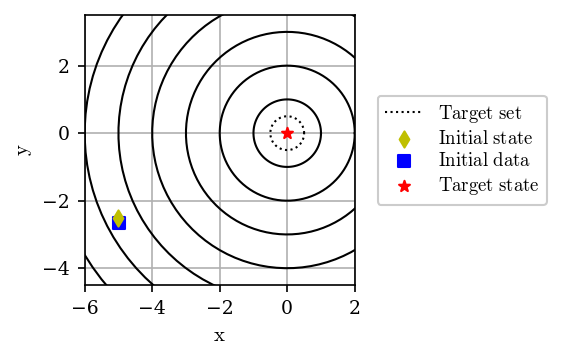

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

# Import plotting functions
from auxillary_functions import *

ax = draw_initial_plot(xlim_tup, ylim_tup, target_position, cost_thresh,
                       initial_state, rand_init_traj_vec)
plt.show()

The unicycle starts at the yellow position and moves along the blue trajectory (training data). Note that the training trajectory pushes the unicycle away from the target (origin).

This completes the problem formulation. We seek one-step controllers that minimize the compute_cost, evaluated at the *unknown* next state, at each iteration. The *unknown* next state is a function of the *known* current state, and the current input, where the latter is the decision variable.

## Proposed approach: `C2Opt` via `congol`

We utilize `SmoothMyopicDataDrivenControl` class provided by `congol` to perform `C2Opt`. Here, we utilize the smoothness of the unknown one-step cost function $C$ to propose minimizers at each step.

We define the **first-order oracle** that evaluates the cost $C$ given a context and input, together denoted by $z\in\mathbb{R}^6$ and computes the gradient  $\nabla C$ with respect to $z$.


0. Current Context: [[-4.99 -2.67  0.99 -0.14]]
Solution strategy: midgap-lp
Using license file /home/abyvinod/gurobi.lic
Academic license - for non-commercial use only
z_query = [[-4.99 -2.67  0.99 -0.14  4.    3.14]] | Optimistic cost = 14.8730 | Time = 0.0070 s 

1. Current Context: [[-5.1  -2.29  0.9  -0.44]]
Solution strategy: midgap-lp
z_query = [[-5.1  -2.29  0.9  -0.44  2.83 -3.14]] | Optimistic cost = 14.6871 | Time = 0.0034 s 

2. Current Context: [[-5.19 -2.02  0.99 -0.14]]
Solution strategy: midgap-lp
z_query = [[-5.19 -2.02  0.99 -0.14  1.78  0.33]] | Optimistic cost = 14.7630 | Time = 0.0063 s 

3. Current Context: [[-5.21 -1.84  0.99 -0.17]]
Solution strategy: midgap-lp
z_query = [[-5.21 -1.84  0.99 -0.17  0.66  3.14]] | Optimistic cost = 14.5382 | Time = 0.0083 s 

4. Current Context: [[-5.24 -1.78  0.88 -0.47]]
Solution strategy: midgap-lp
z_query = [[-5.24 -1.78  0.88 -0.47  0.05  1.27]] | Optimistic cost = 14.4061 | Time = 0.0084 s 

5. Current Context: [[-5.24 -1.7

z_query = [[-0.2   0.88 -0.28 -0.96  2.13 -0.65]] | Optimistic cost = -0.5147 | Time = 0.0991 s 

47. Current Context: [[-0.41  0.82 -0.21 -0.98]]
Solution strategy: midgap-lp
z_query = [[-0.41  0.82 -0.21 -0.98  2.37  0.93]] | Optimistic cost = -0.2177 | Time = 0.0819 s 

48. Current Context: [[-0.64  0.76 -0.3  -0.95]]
Solution strategy: midgap-lp
z_query = [[-0.64  0.76 -0.3  -0.95 -4.   -0.59]] | Optimistic cost = -0.2274 | Time = 0.0885 s 

49. Current Context: [[-0.25  0.87 -0.25 -0.97]]
Solution strategy: midgap-lp
z_query = [[-0.25  0.87 -0.25 -0.97  2.95  2.43]] | Optimistic cost = -0.3565 | Time = 0.1157 s 

50. Current Context: [[-0.53  0.77 -0.47 -0.88]]
Solution strategy: midgap-lp
z_query = [[-0.53  0.77 -0.47 -0.88 -2.98 -1.24]] | Optimistic cost = 0.0184 | Time = 0.0885 s 

51. Current Context: [[-0.26  0.89 -0.36 -0.93]]
Solution strategy: midgap-lp
z_query = [[-0.26  0.89 -0.36 -0.93  4.    1.14]] | Optimistic cost = -0.1772 | Time = 0.0929 s 

52. Current Context: [[

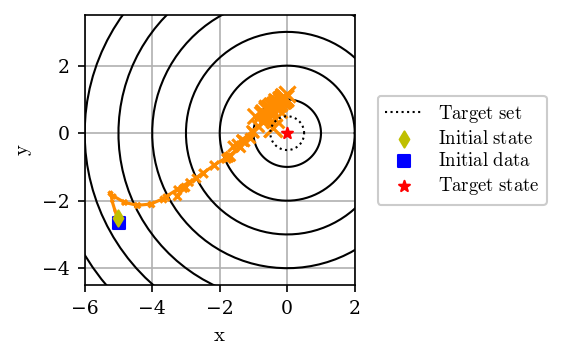

In [6]:
import congol as cg

grad_lips_constant = 1e1                     # Lipschitz constant for the gradient
solver_style = 'midgap-lp' # -cvxpy          # Solution strategies: 'midgap-lp', 'cm-ncvx', 'midgap-lp-cvxpy'
                                             # First two requires Gurobi, while `midgap-lp-cvxpy` 
                                             # only requires CVXPY

# Bounds on the context and the input       
context_u_lb = np.hstack((np.array([xlim_tup[0], ylim_tup[0], -1, -1]), input_lb))
context_u_ub = np.hstack((np.array([xlim_tup[1], ylim_tup[1], 1, 1]), input_ub))        

def first_order_oracle(z_u_data):
    """
    Takes in context+input combination and provides cost function value and its gradient with 
    respect to context+input
    """
    if z_u_data.shape[1] != 6:
        print(z_u_data.shape)
        raise ValueError('Requires feature and input vector (6 col matrix)')

    cost_vec = []
    grad_cost_vec = []
    for z_u in z_u_data:
        x, y, sh, ch, v, w = z_u[:]
        if abs(sh ** 2 + ch ** 2 - 1) > 1e-8:
            print('Error in the user-provided value: sin', sh, '| cos', ch)
            raise ValueError('Expected sin(heading)^2 + cos(heading)^2 == 1')
        if abs(w * sampling_time) >= 1e-5:
            nearly_one = np.sin(w * sampling_time)/(w * sampling_time)
            nearly_zero = (np.cos(w * sampling_time) - 1)/(w * sampling_time)
            # https://www.wolframalpha.com/input/?i=simplify+d%2Fdw+sin%28wt%29%2F%28wt%29
            # (t w cos(t w) - sin(t w))/(t w^2)
            nearly_one_dw = (sampling_time * w * np.cos(sampling_time * w)
                             - np.sin(sampling_time * w)) \
                                                    /(sampling_time * (w ** 2))
            # https://www.wolframalpha.com/input/?i=simplify+d%2Fdw+%28cos%28wt%29+-+1%29%2F%28wt%29
            # -(t w sin(t w) + cos(t w) - 1)/(t w^2)
            nearly_zero_dw = - (sampling_time * w * np.sin( sampling_time * w)
                                + np.cos(sampling_time * w) - 1) \
                                                    /(sampling_time * (w ** 2))
        else:
            nearly_zero = 0
            nearly_one = 1
            # They are constants
            nearly_zero_dw = 0
            nearly_one_dw = 0

        # Change in position
        delta_x = v * sampling_time * (ch * nearly_one + sh * nearly_zero)
        delta_y = v * sampling_time * (sh * nearly_one - ch * nearly_zero)

        # Cost definition
        current_state = np.array([[x, y, np.arctan2(sh, ch)]])
        current_input = np.array([[v, w]])
        next_state = one_step_dyn(current_state, current_input)
        cost_vec = np.hstack((cost_vec, compute_cost(next_state)))

        # Components of the gradient via chain rule
        cost_dx = 2 * (x + delta_x - target_position[0])
        cost_dy = 2 * (y + delta_y - target_position[1])
        cost_dsh = cost_dx * (v * sampling_time * nearly_zero) +\
                   cost_dy * (v * sampling_time * nearly_one)
        cost_dch = cost_dx * (v * sampling_time * nearly_one) -\
                   cost_dy * (v * sampling_time * nearly_zero)
        cost_dv = cost_dx * sampling_time * (ch * nearly_one + sh* nearly_zero)\
                + cost_dy * sampling_time * (sh * nearly_one - ch* nearly_zero)
        cost_dw = cost_dx*v*sampling_time*(ch*nearly_one_dw+sh*nearly_zero_dw)\
                + cost_dy*v*sampling_time*(sh*nearly_one_dw-ch*nearly_zero_dw)
        grad_cost = [cost_dx, cost_dy, cost_dsh, cost_dch, cost_dv, cost_dw]
        grad_cost_vec.append(grad_cost)

    return cost_vec, np.array(grad_cost_vec)/2

# Compute the context+input vector and the associated costs and the gradients
rand_init_context_input_vec = np.hstack((state_to_context(rand_init_traj_vec[:-1, :]), rand_init_input_vec))
rand_init_cost_val_vec, rand_init_cost_grad_vec = first_order_oracle(rand_init_context_input_vec) 

# Training data packaged for C2Opt
training_data = {'trajectory': rand_init_traj_vec,
                 'input_seq': rand_init_input_vec,
                 'cost_val': rand_init_cost_val_vec,
                 'cost_grad': rand_init_cost_grad_vec}

# Provide `congol` all the information available about the problem for C2Opt
sm_ddc = cg.SmoothMyopicDataDrivenControl(training_data,
                                         state_to_context, 
                                         context_u_lb, 
                                         context_u_ub, 
                                         first_order_oracle, 
                                         grad_lips_constant, 
                                         one_step_dyn=one_step_dyn,
                                         exit_condition=exit_condition,
                                         solver_style=solver_style)

ax = draw_initial_plot(xlim_tup, ylim_tup, target_position, cost_thresh,
                       initial_state, rand_init_traj_vec)

# Compute the solution for max_oracle_calls (time steps) or till exit_condition is true, whichever is earliest
# Set verbose to true if the evolution of the cost and context is desired
# Set draw_plots_at_the_end to False if the trajectory evolution is desired
res_sm_ddc = sm_ddc.solve(max_oracle_calls, ax=ax, draw_plots_at_the_end=True, verbose=True)

### Retrieve the trajectory and cost information from `sm_ddc` object

Obtain the resulting sequence of contexts, input sequence, trajectory, and cost vector from `sm_ddc` object.

In [7]:
# Retrieve the context vector followed by C2Opt
context_vec = sm_ddc.contextual_optimizer.objective.arg[:,:sm_ddc.context_arg_dim]
# Retrieve the input sequence followed by C2Opt
c2opt_input_vec = sm_ddc.contextual_optimizer.objective.arg[:,sm_ddc.context_arg_dim:]
# Retrieve the trajectory followed by C2Opt
c2opt_x, c2opt_y, c2opt_sh, c2opt_ch = context_vec.T
c2opt_traj_vec = np.vstack((c2opt_x, c2opt_y, np.arctan2(c2opt_sh, c2opt_ch))).T
# Add to the trajectory the last state that caused the exit condition to be true
c2opt_traj_vec = np.vstack((c2opt_traj_vec, one_step_dyn(c2opt_traj_vec[-1,:], c2opt_input_vec[-1,:])))
# Retrieve the cost vector achieved by C2Opt
c2opt_cost_vec = compute_cost(c2opt_traj_vec)    #sm_ddc.contextual_optimizer.objective.fun

## Comparison algorithm 1: Optimal trajectory using the knowledge of the true dynamics?

In the scenario where the dynamics $F$ were known, we could have solved the nonlinear optimization problem,
$$u_t^\ast = \arg\inf_{u\in\mathcal{U}} c(x_t,u,F(x_t,u))$$
directly to compute the optimal one-step control. This *optimal trajectory* is the best performance we could hope for using a one-step receding horizon control framework. We implement this approach using `scipy.optimize`.


0. Current state: [[-5.   -2.5   1.57]] | Initial action guess: [-4.   -3.14]
Solver method: L-BFGS-B
Best action = [[ 4.   -3.14]] | Attained cost = 14.4091 | Time = 0.0014 s 

1. Current state: [[-4.76 -1.75  0.94]] | Initial action guess: [-4.   -3.14]
Solver method: L-BFGS-B
Best action = [[ 4.   -3.14]] | Attained cost = 11.0938 | Time = 0.0016 s 

2. Current state: [[-4.12 -1.29  0.31]] | Initial action guess: [-4.   -3.14]
Solver method: L-BFGS-B
Best action = [[ 4.   -0.17]] | Attained cost = 7.6721 | Time = 0.0023 s 

3. Current state: [[-3.36 -1.05  0.28]] | Initial action guess: [-4.   -3.14]
Solver method: L-BFGS-B
Best action = [[4.   0.37]] | Attained cost = 4.8586 | Time = 0.0024 s 

4. Current state: [[-2.6  -0.8   0.35]] | Initial action guess: [-4.   -3.14]
Solver method: L-BFGS-B
Best action = [[ 4.   -0.84]] | Attained cost = 2.6857 | Time = 0.0036 s 

5. Current state: [[-1.83 -0.59  0.19]] | Initial action guess: [-4.   -3.14]
Solver method: L-BFGS-B
Best action 

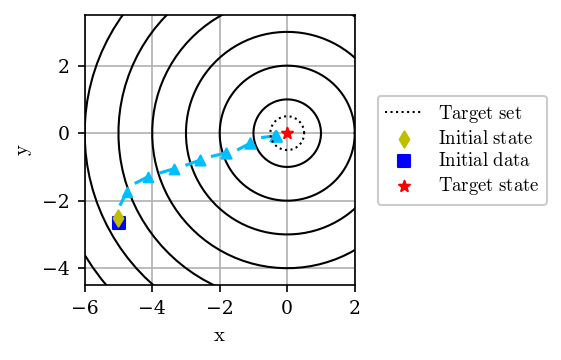

In [8]:
# See the module MyopicDataDrivenControlTrue for scipy.optimize-based solution to
# myopic data-driven control when dynamics is known
from MyopicDataDrivenControlTrue import MyopicDataDrivenControlTrue

# Training data packaged for CGP-LCB
training_data = {'trajectory': rand_init_traj_vec,
                 'input_seq': rand_init_input_vec,
                 'cost_val': rand_init_cost_val_vec}

def true_objective(current_state, current_input):
    next_state = one_step_dyn(current_state, current_input)
    return compute_cost(next_state)
        

# Provide `gpyopt` all the information available about the problem for CGP-LCB
true_ddc = MyopicDataDrivenControlTrue(training_data, 
                                       input_lb, 
                                       input_ub, 
                                       true_objective,
                                       one_step_dyn=one_step_dyn,
                                       exit_condition=exit_condition)

ax = draw_initial_plot(xlim_tup, ylim_tup, target_position, cost_thresh,
                       initial_state, rand_init_traj_vec)

# Compute the solution for max_oracle_calls (time steps) or till exit_condition is true, whichever is earliest
# Set verbose to true if the evolution of the cost and context is desired
# Set draw_plots_at_the_end to False if the trajectory evolution is desired
res_true_ddc = true_ddc.solve(max_oracle_calls, ax=ax, draw_plots_at_the_end=True, verbose=True)

In [9]:
# Retrieve the optimal trajectory
opt_traj_vec = true_ddc.trajectory
# Add to the trajectory the last state that caused the exit condition to be true
opt_traj_vec = np.vstack((opt_traj_vec, one_step_dyn(opt_traj_vec[-1,:], true_ddc.input_seq[-1,:])))
# Retrieve the cost vector achieved by C2Opt
opt_cost_vec = compute_cost(opt_traj_vec)      #true_ddc.cost_val_vec

## Comparison algorithm 2: `CGP-LCB` via `GPyOpt`

We utilize Bayesian optimization to optimize the unknown one-step cost function $C$, and achieve near-optimal, one-step, data-driven control.

The set cost function is ignored! LCB acquisition does not make sense with cost.

0. Current context: [[-4.99 -2.67  0.99 -0.14]]
Acquisition type: LCB | Acquisition optimizer type: lbfgs
z_query = [[-4.99 -2.67  0.99 -0.14 -3.78 -2.89]] | Cost estimate = 17.0840 | Time = 0.1327 s 
The set cost function is ignored! LCB acquisition does not make sense with cost.

1. Current context: [[-4.99 -3.04  0.99  0.15]]
Acquisition type: LCB | Acquisition optimizer type: lbfgs
z_query = [[-4.99 -3.04  0.99  0.15 -1.67  1.38]] | Cost estimate = 17.6713 | Time = 0.2731 s 
The set cost function is ignored! LCB acquisition does not make sense with cost.

2. Current context: [[-5.   -3.21  1.    0.01]]
Acquisition type: LCB | Acquisition optimizer type: lbfgs
z_query = [[-5.   -3.21  1.    0.01 -3.55  0.65]] | Cost estimate = 18.8363 | Time = 0.2546 s 
The set cost function is ignored! LCB acquisition does not make sense with cost.

3. Current context: [[-5.   -3.56  1.   -0.05]]
Acquisition type: LCB

Acquisition type: LCB | Acquisition optimizer type: lbfgs
z_query = [[-5.41 -2.31  0.99  0.11  2.08 -2.92]] | Cost estimate = 16.5764 | Time = 0.3609 s 
The set cost function is ignored! LCB acquisition does not make sense with cost.

30. Current context: [[-5.36 -2.11  0.92  0.39]]
Acquisition type: LCB | Acquisition optimizer type: lbfgs
z_query = [[-5.36 -2.11  0.92  0.39  3.   -0.12]] | Cost estimate = 15.4010 | Time = 0.3749 s 
The set cost function is ignored! LCB acquisition does not make sense with cost.

31. Current context: [[-5.24 -1.84  0.91  0.4 ]]
Acquisition type: LCB | Acquisition optimizer type: lbfgs
z_query = [[-5.24 -1.84  0.91  0.4   3.08  0.72]] | Cost estimate = 14.3265 | Time = 0.3981 s 
The set cost function is ignored! LCB acquisition does not make sense with cost.

32. Current context: [[-5.12 -1.55  0.94  0.34]]
Acquisition type: LCB | Acquisition optimizer type: lbfgs
z_query = [[-5.12 -1.55  0.94  0.34  3.92  0.79]] | Cost estimate = 13.2219 | Time = 0.407

Acquisition type: LCB | Acquisition optimizer type: lbfgs
z_query = [[-1.24  1.97 -0.28  0.96  4.    3.14]] | Cost estimate = 2.1993 | Time = 0.7112 s 
The set cost function is ignored! LCB acquisition does not make sense with cost.

59. Current context: [[-0.85  1.92  0.03  1.  ]]
Acquisition type: LCB | Acquisition optimizer type: lbfgs
z_query = [[-0.85  1.92  0.03  1.    1.69 -3.14]] | Cost estimate = 2.0312 | Time = 0.7889 s 
The set cost function is ignored! LCB acquisition does not make sense with cost.

60. Current context: [[-0.68  1.9  -0.28  0.96]]
Acquisition type: LCB | Acquisition optimizer type: lbfgs
z_query = [[-0.68  1.9  -0.28  0.96  4.    0.58]] | Cost estimate = 1.6568 | Time = 0.7587 s 
The set cost function is ignored! LCB acquisition does not make sense with cost.

61. Current context: [[-0.29  1.8  -0.22  0.97]]
Acquisition type: LCB | Acquisition optimizer type: lbfgs
z_query = [[-0.29  1.8  -0.22  0.97  4.   -3.14]] | Cost estimate = 1.3605 | Time = 0.6326 s 

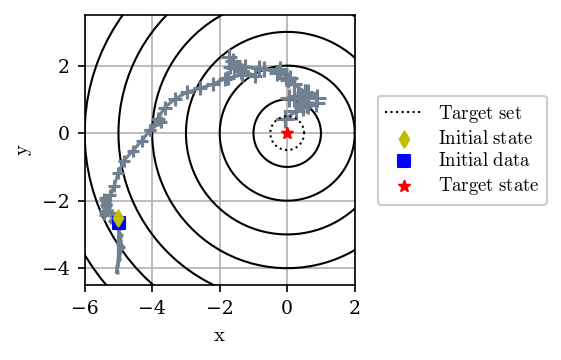

In [10]:
# See the module MyopicDataDrivenControlContextGP for more details on how CGP-LCB
# provided in GPyOpt was utilized for myopic data-driven control
from MyopicDataDrivenControlContextGP import MyopicDataDrivenControlContextGP

acquistion_type = 'LCB'

# Training data packaged for CGP-LCB
training_data = {'trajectory': rand_init_traj_vec,
                 'input_seq': rand_init_input_vec,
                 'cost_val': rand_init_cost_val_vec}

def bo_objective(context_u):
    cost_vec = []
    for z_u in context_u:
        x, y, sh, ch, v, w = z_u[:]
        current_state = np.array([[x, y, np.arctan2(sh, ch)]])
        current_input = np.array([[v, w]])
        cost_vec.append(compute_cost(one_step_dyn(current_state, current_input)))
    return np.array(cost_vec)
        

# Provide `gpyopt` all the information available about the problem for CGP-LCB
gp_ddc = MyopicDataDrivenControlContextGP(training_data, 
                                         state_to_context, 
                                         context_u_lb, 
                                         context_u_ub, 
                                         bo_objective,
                                         one_step_dyn=one_step_dyn,
                                         exit_condition=exit_condition,
                                         solver_style=acquistion_type)

ax = draw_initial_plot(xlim_tup, ylim_tup, target_position, cost_thresh,
                       initial_state, rand_init_traj_vec)

# Compute the solution for max_oracle_calls (time steps) or till exit_condition is true, whichever is earliest
# Set verbose to true if the evolution of the cost and context is desired
# Set draw_plots_at_the_end to False if the trajectory evolution is desired
res_gp_ddc = gp_ddc.solve(max_oracle_calls, ax=ax, draw_plots_at_the_end=True, verbose=True)

### Retrieve the trajectory and cost information from `gp_ddc` object

Obtain the resulting sequence of contexts, input sequence, trajectory, and cost vector from `gp_ddc` object.

In [11]:
# Retrieve the context vector followed by GPyOpt (CGP-LCB)
context_vec = gp_ddc.bo_step.X[:,:gp_ddc.context_arg_dim]
# Retrieve the input sequence followed by GPyOpt (CGP-LCB)
gpyopt_input_vec = gp_ddc.bo_step.X[:,gp_ddc.context_arg_dim:]
# Retrieve the trajectory followed by GPyOpt (CGP-LCB)
gpyopt_x, gpyopt_y, gpyopt_sh, gpyopt_ch = context_vec.T
gpyopt_traj_vec = np.vstack((gpyopt_x, gpyopt_y, np.arctan2(gpyopt_sh, gpyopt_ch))).T
# Add to the trajectory the last state that caused the exit condition to be true
gpyopt_traj_vec = np.vstack((gpyopt_traj_vec, one_step_dyn(gpyopt_traj_vec[-1,:], gpyopt_input_vec[-1,:])))
# Retrieve the cost vector achieved by GPyOpt (CGP-LCB)
gpyopt_cost_vec = compute_cost(gpyopt_traj_vec)    #gp_ddc.bo_step.Y[:, 0]

## Comparison algorithm 3: `SINDYc`

We also compare our approach with SINDYc, sparse identification of nonlinear dynamics with control. Here, we utilize data to identify a model for the control, on which one-step receding horizon control is performed.


0. Current state: [[-5.   -2.5   1.57]]
Either candidate conic solvers (['ECOS']) do not support the cones output by the problem (PSD), or there are not enough constraints in the problem.


>>> SINDYc approach failed due to numerical issues!
Terminating early!


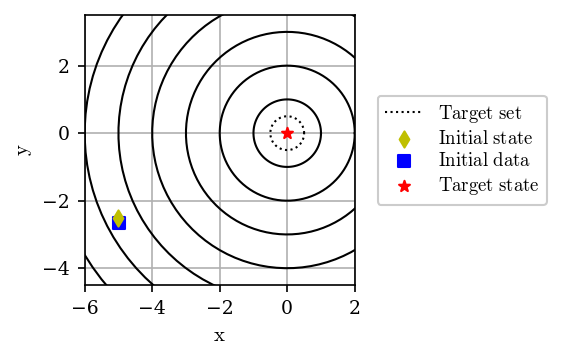

In [12]:
# See the module MyopicDataDrivenControlSINDYc for more details on how SINDYc
# was utilized for myopic data-driven control
from MyopicDataDrivenControlSINDYc import MyopicDataDrivenControlSINDYc

cvxpy_args = {'solver':'ECOS'}

# Training data packaged for CGP-LCB
training_data = {'trajectory': rand_init_traj_vec,
                 'input_seq': rand_init_input_vec,
                 'cost_val': rand_init_cost_val_vec}

# Define sindyc_ddc object
sindyc_ddc = MyopicDataDrivenControlSINDYc(training_data, 
                                           input_lb, 
                                           input_ub, 
                                           cvxpy_objective,
                                           sampling_time,
                                           one_step_dyn=one_step_dyn,
                                           exit_condition=exit_condition,
                                           cvxpy_args=cvxpy_args)

ax = draw_initial_plot(xlim_tup, ylim_tup, target_position, cost_thresh,
                       initial_state, rand_init_traj_vec)

# Compute the solution for max_oracle_calls (time steps) or till exit_condition is true, whichever is earliest
# Set verbose to true if the evolution of the cost and context is desired
# Set draw_plots_at_the_end to False if the trajectory evolution is desired
res_sindyc_ddc = sindyc_ddc.solve(max_oracle_calls, ax=ax, draw_plots_at_the_end=True, verbose=True)

### Retrieve the trajectory and cost information from `sindyc_ddc` object

Obtain the resulting sequence of contexts, input sequence, trajectory, and cost vector from `sindyc_ddc` object.

In [13]:
# Retrieve the optimal trajectory
sindyc_traj_vec = sindyc_ddc.trajectory
# Add to the trajectory the last state that caused the exit condition to be true
sindyc_traj_vec = np.vstack((sindyc_traj_vec, one_step_dyn(sindyc_traj_vec[-1,:], sindyc_ddc.input_seq[-1,:])))
# Retrieve the cost vector achieved by C2Opt
sindyc_cost_vec = compute_cost(sindyc_traj_vec)       #sindyc_ddc.cost_val_vec

## Computation times for each of the methods

`C2Opt` is computationally faster (around 3 times) than `CGP-LCB`, since it leverages convexity. Note that this difference is even higher when using commericial solvers like `GUROBI`.

`C2Opt` is also faster than `SINDYc` and does not suffer numerical issues. On the other hand, `SINDYc` takes fewer iterations to get close to the target.

In [14]:
t_true_ddc = [t['query_time'] for t in res_true_ddc]
t_sm_ddc = [t['query_time'] for t in res_sm_ddc]
t_gp_ddc = [t['query_time'] for t in res_gp_ddc]
t_sindyc_ddc = [t['query_time'] for t in res_sindyc_ddc]

import csv
import pandas as pd
pd.set_option("display.precision", 4)
with open(fig_name_prefix + 'compute_time_stats.csv', 'w', newline='') as csvfile:
    fieldnames = [' ', 'C2Opt', 'CGP-LCB', 'SINDYc', 'True']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerow({' ': 'Number of iterations', 'C2Opt': len(t_sm_ddc), 'CGP-LCB': len(t_gp_ddc),
                     'SINDYc': len(t_sindyc_ddc), 'True': len(t_true_ddc)})
    writer.writerow({' ': 'Average compute time per iteration', 'C2Opt': np.mean(t_sm_ddc), 
                     'CGP-LCB': np.mean(t_gp_ddc), 'SINDYc': np.mean(t_sindyc_ddc), 'True': np.mean(t_true_ddc)})
    writer.writerow({' ': 'Maximum compute time per iteration', 'C2Opt': np.max(t_sm_ddc), 'CGP-LCB': np.max(t_gp_ddc), 
                     'SINDYc': np.max(t_sindyc_ddc), 'True': np.max(t_true_ddc)})
    writer.writerow({' ': 'Total compute time (all iterations)', 'C2Opt': np.sum(t_sm_ddc), 
                     'CGP-LCB': np.sum(t_gp_ddc), 'SINDYc': np.sum(t_sindyc_ddc), 'True': np.sum(t_true_ddc)})

compute_time_table = pd.read_csv(fig_name_prefix + 'compute_time_stats.csv')
blankIndex=[''] * len(compute_time_table)
compute_time_table.index=blankIndex
print(compute_time_table)

                                         C2Opt  CGP-LCB  SINDYc    True
                 Number of iterations  75.0000  80.0000     1.0  7.0000
   Average compute time per iteration   0.0715   0.9511     inf  0.0021
   Maximum compute time per iteration   0.1598   5.0195     inf  0.0036
  Total compute time (all iterations)   5.3639  76.0886     inf  0.0149


## Comparison plots

Note that `CGP-LCB` and `C2Opt` demonstrate similar reduction in costs. However `CGP-LCB` typically arrives at the target set faster than `C2Opt`.

As expected, the knowledge of the true dynamics enables faster arrival at the target set.

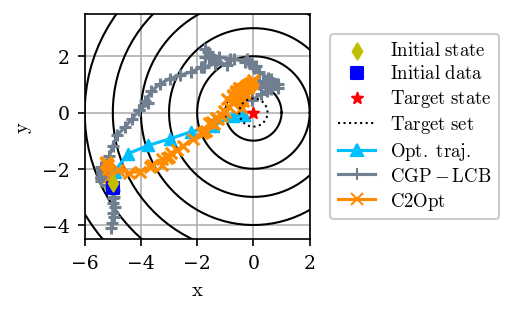

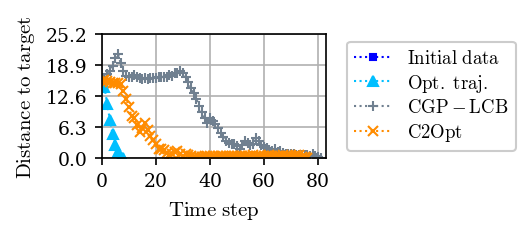

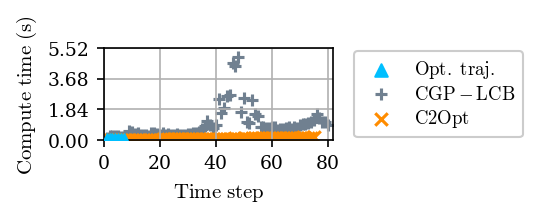

In [20]:
from matplotlib.ticker import FormatStrFormatter

# skip_marker and traj_markersize are defined in auxillary_function module
# Draw all the trajectories
ax = draw_initial_plot(xlim_tup, ylim_tup, target_position, cost_thresh,
                       initial_state, rand_init_traj_vec)
# True optimal trajectory (first plot interpolates the points, then scatter plot provides the precise 
# locations, and finally the last plot provides the legend)
plt.plot(opt_traj_vec[n_data_max:, 0], opt_traj_vec[n_data_max:, 1], color=true_ddc.marker_color)
plt.scatter(opt_traj_vec[n_data_max::, 0], opt_traj_vec[n_data_max::, 1],
            traj_markersize, color=true_ddc.marker_color, marker=true_ddc.marker_type, 
            zorder=true_ddc.zorder)    
ax.plot(opt_traj_vec[-1:, 0], opt_traj_vec[-1:, 1],'-' + true_ddc.marker_type,  
        ms = np.sqrt(traj_markersize), color=true_ddc.marker_color, label=true_ddc.marker_label)
# GPyOpt (first plot interpolates the points, then scatter plot provides the precise locations, and
# finally the last plot provides the legend)
plt.plot(gpyopt_traj_vec[n_data_max:, 0], gpyopt_traj_vec[n_data_max:, 1], color=gp_ddc.marker_color)
plt.scatter(gpyopt_traj_vec[n_data_max::skip_marker, 0], gpyopt_traj_vec[n_data_max::skip_marker, 1],
            traj_markersize, color=gp_ddc.marker_color, marker=gp_ddc.marker_type, 
            zorder=gp_ddc.zorder)
ax.plot(gpyopt_traj_vec[-1:, 0], gpyopt_traj_vec[-1:, 1],'-' + gp_ddc.marker_type,  
        ms = np.sqrt(traj_markersize), color=gp_ddc.marker_color, label=gp_ddc.marker_label)
# SINDYc (first plot interpolates the points, then scatter plot provides the precise locations, and
# finally the last plot provides the legend)    
if len(res_sindyc_ddc) > 1:
    plt.plot(sindyc_traj_vec[n_data_max:, 0], sindyc_traj_vec[n_data_max:, 1], color=sindyc_ddc.marker_color)
    plt.scatter(sindyc_traj_vec[n_data_max::skip_marker, 0], sindyc_traj_vec[n_data_max::skip_marker, 1],
                traj_markersize, color=sindyc_ddc.marker_color, marker=sindyc_ddc.marker_type, 
                zorder=sindyc_ddc.zorder)
    ax.plot(sindyc_traj_vec[-1:, 0], sindyc_traj_vec[-1:, 1],'-' + sindyc_ddc.marker_type,  
            ms = np.sqrt(traj_markersize), color=sindyc_ddc.marker_color, label=sindyc_ddc.marker_label)
# C2Opt (first plot interpolates the points, then scatter plot provides the precise locations, and
# finally the last plot provides the legend)
plt.plot(c2opt_traj_vec[n_data_max:, 0], c2opt_traj_vec[n_data_max:, 1], color=sm_ddc.marker_color)
plt.scatter(c2opt_traj_vec[n_data_max::skip_marker, 0], c2opt_traj_vec[n_data_max::skip_marker, 1],
            traj_markersize, color=sm_ddc.marker_color, marker=sm_ddc.marker_type, 
            zorder=sm_ddc.zorder)    
ax.plot(c2opt_traj_vec[-1:, 0], c2opt_traj_vec[-1:, 1],'-' + sm_ddc.marker_type,  
        ms = np.sqrt(traj_markersize), color=sm_ddc.marker_color, label=sm_ddc.marker_label)
# Reorder the legend
handles, labels = plt.gca().get_legend_handles_labels()
if len(res_sindyc_ddc) > 1:
    order = [5,7,6,0,1,2,3,4]
else:
    order = [4,5,6,0,1,2,3]
ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], 
          ncol=1, labelspacing=0.25, framealpha=1, loc='center left',
          bbox_to_anchor=(1.05, 0.5))
# plt.tight_layout()
plt.subplots_adjust(top=0.85, bottom=0.25, left=0.0, right=0.82, hspace=0.0, wspace=0.0)
plt.savefig(fig_name_prefix + 'Trajectory.svg', transparent=True)
plt.savefig(fig_name_prefix + 'Trajectory.png', dpi=300)

fig_height_scaling = 0.55
# Draw the cost functions
cost_linewidth = 1
cost_markersize = 5
fig = plt.figure(figsize=(fig_width, fig_height * fig_height_scaling), dpi=fig_dpi)
ax = fig.gca()
plt.plot(rand_init_cost_val_vec, marker = 's', linestyle = ':', linewidth=cost_linewidth, 
         ms = cost_markersize * 2/3, color='b', label=r'$\mathrm{Initial\ data}$')
# Optimal trajectory
plt.plot(range(n_data_max-1, len(opt_cost_vec)), opt_cost_vec[n_data_max-1:], marker = true_ddc.marker_type, 
         linestyle = ':', linewidth=cost_linewidth, ms = cost_markersize, color=true_ddc.marker_color, 
         label=true_ddc.marker_label)
# GPyOpt
plt.plot(range(n_data_max-1, len(gpyopt_cost_vec)), gpyopt_cost_vec[n_data_max-1:], marker = gp_ddc.marker_type, 
         linestyle = ':', linewidth=cost_linewidth, ms = cost_markersize, color=gp_ddc.marker_color, 
         label=gp_ddc.marker_label)
# SINDYc
if len(res_sindyc_ddc) > 1:
    plt.plot(range(n_data_max-1, len(sindyc_cost_vec)), sindyc_cost_vec[n_data_max-1:], marker = sindyc_ddc.marker_type, 
             linestyle = ':', linewidth=cost_linewidth, ms = cost_markersize, color=sindyc_ddc.marker_color, 
             label=sindyc_ddc.marker_label)
# C2Opt
plt.plot(range(n_data_max-1, len(c2opt_cost_vec)), c2opt_cost_vec[n_data_max-1:], marker = sm_ddc.marker_type, 
         linestyle = ':', linewidth=cost_linewidth, ms = cost_markersize, color=sm_ddc.marker_color, 
         label=sm_ddc.marker_label)
plt.xlabel(r'$\mathrm{Time\ step} $', fontsize = fig_fontsize)
plt.ylabel(r'$\mathrm{Distance\ to\ target}$', fontsize = fig_fontsize)
max_y = np.round(max([max(opt_cost_vec), max(gpyopt_cost_vec), max(c2opt_cost_vec)])) * 1.2
compute_time_x_max = np.max([len(res_sm_ddc), len(res_gp_ddc), len(res_sindyc_ddc)]) + n_data_max + 1
ax.set_ylim([0, max_y])
ax.set_xlim([0, max([len(opt_cost_vec), len(gpyopt_cost_vec), len(c2opt_cost_vec)]) + 1])
plt.yticks(np.linspace(0, max_y, 5))
plt.legend(ncol=1, labelspacing = 0.25, framealpha = 1, loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.grid()
# plt.tight_layout()
if figure_3:
    plt.subplots_adjust(top=0.9, bottom=0.3, left=0.14, right=0.62, hspace=0.0, wspace=0.0)
    plt.xticks(np.arange(n_data_max, compute_time_x_max, 10))
else:
    plt.subplots_adjust(top=0.9, bottom=0.3, left=0.18, right=0.62, hspace=0.0, wspace=0.0)
    plt.xticks(np.arange(0, compute_time_x_max, 20))
plt.savefig(fig_name_prefix + 'Cost.svg', transparent=True)
plt.savefig(fig_name_prefix + 'Cost.png', dpi=300)


fig_height_scaling = 1/2
fig = plt.figure(figsize=(fig_width, fig_height * fig_height_scaling), dpi=fig_dpi)
ax = fig.gca()
if len(res_sindyc_ddc) > 1:
    compute_time_y_max = np.max(np.hstack((t_true_ddc, t_sm_ddc, t_sindyc_ddc, t_gp_ddc))) * 1.1
else:
    compute_time_y_max = np.max(np.hstack((t_true_ddc, t_sm_ddc, t_gp_ddc))) * 1.1
ax.scatter(range(n_data_max, len(res_true_ddc)+n_data_max), t_true_ddc, color=true_ddc.marker_color, 
           marker=true_ddc.marker_type, label=true_ddc.marker_label,zorder=10)
ax.scatter(range(n_data_max, len(res_gp_ddc)+n_data_max), t_gp_ddc, color=gp_ddc.marker_color, 
           marker=gp_ddc.marker_type, label=gp_ddc.marker_label)
if len(res_sindyc_ddc) > 1:
    ax.scatter(range(n_data_max, len(res_sindyc_ddc)+n_data_max), t_sindyc_ddc, color=sindyc_ddc.marker_color, 
               marker=sindyc_ddc.marker_type, label=sindyc_ddc.marker_label,zorder=10)
ax.scatter(range(n_data_max, len(res_sm_ddc)+n_data_max), t_sm_ddc, color=sm_ddc.marker_color, 
           marker=sm_ddc.marker_type, label=sm_ddc.marker_label)
# ax.set_yscale('log')
plt.xlim([n_data_max, compute_time_x_max])
plt.ylim([0, compute_time_y_max])
plt.yticks(10*np.linspace(0, compute_time_y_max, 4)/10)
ax.yaxis.set_major_formatter(FormatStrFormatter('%1.2f'))
plt.xlabel(r'$\mathrm{Time\ step} $', fontsize = fig_fontsize)
plt.ylabel(r'$\mathrm{Compute\ time\ (s)}$', fontsize = fig_fontsize)
plt.grid()
ax.legend(ncol=1, labelspacing=0.25, framealpha=1, loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.subplots_adjust(top=0.82, bottom=0.33, left=0.17, right=0.62, hspace=0.0, wspace=0.0)
if figure_3:
    plt.xticks(np.arange(n_data_max, compute_time_x_max, 10))
else:
    plt.xticks(np.arange(0, compute_time_x_max, 20))
plt.savefig(fig_name_prefix + 'ComputeTime.svg', transparent=True)
plt.savefig(fig_name_prefix + 'ComputeTime.png', dpi=300)
plt.show()